In [1]:
# Real Time Machine Learning 
# HW3
# Shanle Yao
# 800962310

## Q1.1

In [2]:
import time
import datetime
import numpy as np
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name())
    print("Memory Usage:")
    print("\tAllocated:", round(torch.cuda.memory_allocated()/1024**3,1), "GB")
    print("\tCached:", round(torch.cuda.memory_reserved()/1024**3,1), "GB")
#device = torch.device('cpu')

Using device:  cuda

NVIDIA GeForce RTX 3070 Ti
Memory Usage:
	Allocated: 0.0 GB
	Cached: 0.0 GB


In [4]:
class CNN(nn.Module):
    def __init__(self, n_channels1 = 32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_channels1, (self.n_channels1 // 2), kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * (self.n_channels1 // 2), 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = f.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * (self.n_channels1 // 2))
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [5]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

In [6]:
# Download the cifar10 dataset.
data = '.\cifar10'
cirfar10_train = datasets.CIFAR10(data, train=True, download=True, transform=transforms)
cirfar10_val = datasets.CIFAR10(data, train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f"Training on {device}")

Training on cuda


In [8]:
def training_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        correct_labels = 0
        count = 0
        loss_val_value = 0
        
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                output = model(imgs)
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)

                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            loss_val_value /= len(val_loader)
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count)
        
        model.train()
        loss_train_value = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss_train = loss_fn(output, labels)
            loss_train_value += float(loss_train)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        loss_train_value /= len(train_loader)
        training_losses.append(loss_train_value)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train_value}", end="")
            print(f", Validation Loss: {loss_val_value}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

In [9]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

model = CNN().to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [10]:
try:
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)
        
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.3030111205821133, Validation Loss: 2.3091917037963867, Accuracy: 9.93%
Epoch: 10, Training Loss: 1.8928164365340252, Validation Loss: 1.9013160943984986, Accuracy: 32.41%
Epoch: 20, Training Loss: 1.632048064348649, Validation Loss: 1.6378007769584655, Accuracy: 42.14%
Epoch: 30, Training Loss: 1.4704824953663105, Validation Loss: 1.4654663681983948, Accuracy: 47.449999999999996%
Epoch: 40, Training Loss: 1.3845055784497942, Validation Loss: 1.3953380823135375, Accuracy: 49.18%
Epoch: 50, Training Loss: 1.3140918308374834, Validation Loss: 1.3547123074531555, Accuracy: 51.31%
Epoch: 60, Training Loss: 1.264514035108138, Validation Loss: 1.2797291994094848, Accuracy: 54.0%
Epoch: 70, Training Loss: 1.2208043044927168, Validation Loss: 1.230396854877472, Accuracy: 56.120000000000005%
Epoch: 80, Training Loss: 1.1838381071479953, Validation Loss: 1.2103164315223693, Accuracy: 57.15%
Epoch: 90, Training Loss: 1.1408535485364952, Validation Loss: 1.177109873294830

Text(0.5, 1.0, 'Q1.1 Accuracy')

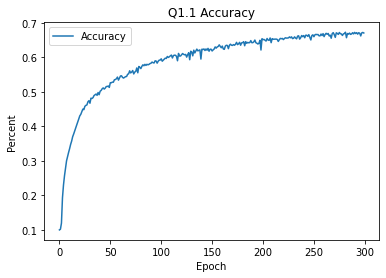

In [11]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Percent")

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Q1.1 Accuracy")

Text(0.5, 1.0, 'Q1.1 Loss')

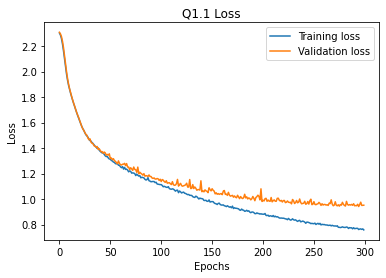

In [12]:
fig = plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Q1.1 Loss")

## Q1.2

In [13]:
class CNN2(nn.Module):
    def __init__(self, n_channels1 = 32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_channels1, (self.n_channels1 // 2), kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d((self.n_channels1 // 2), (self.n_channels1 // 4), kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(4 * 4 * (self.n_channels1 // 4), 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = f.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = f.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * (self.n_channels1 // 4))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

model = CNN2().to(device=device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [15]:
try:
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)

print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.306285926273891, Validation Loss: 2.3083279848098757, Accuracy: 10.0%
Epoch: 10, Training Loss: 2.1518848136979707, Validation Loss: 2.161203694343567, Accuracy: 23.13%
Epoch: 20, Training Loss: 1.9744566508701868, Validation Loss: 1.9697188019752503, Accuracy: 28.139999999999997%
Epoch: 30, Training Loss: 1.8696507434455716, Validation Loss: 1.8697588682174682, Accuracy: 32.23%
Epoch: 40, Training Loss: 1.7229783851273206, Validation Loss: 1.7212650299072265, Accuracy: 37.980000000000004%
Epoch: 50, Training Loss: 1.6200466131677433, Validation Loss: 1.619368577003479, Accuracy: 41.38%
Epoch: 60, Training Loss: 1.5439238450965103, Validation Loss: 1.5381970882415772, Accuracy: 44.62%
Epoch: 70, Training Loss: 1.4727090913422254, Validation Loss: 1.4712493896484375, Accuracy: 46.7%
Epoch: 80, Training Loss: 1.4244154740353019, Validation Loss: 1.4303059339523316, Accuracy: 48.13%
Epoch: 90, Training Loss: 1.3888991779210615, Validation Loss: 1.389922189712524

Text(0.5, 1.0, 'Q1.2 Accuracy')

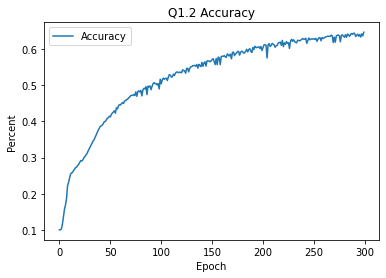

In [16]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Percent")

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Q1.2 Accuracy")

Text(0.5, 1.0, 'Q1.2 Loss')

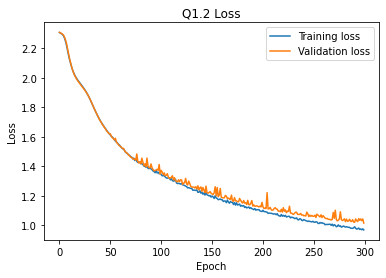

In [17]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Q1.2 Loss")

In [20]:
from ptflops import get_model_complexity_info
model_p1a = CNN()
model_p1b = CNN2()

macs, params = get_model_complexity_info(model_p1a, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
print("Q1.1")
print("Model size: " + params)
      
print("")

macs, params = get_model_complexity_info(model_p1b, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
print("Q1.2")
print("Model size: " + params)


Q1.1
Model size: 38.65 k

Q1.2
Model size: 11.14 k


## Q2.1

In [21]:
class ResNet(nn.Module):
    def __init__(self, n_channels1, n_blocks):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.blocks = nn.Sequential(*(n_blocks * [ResBlock(n_channels1=self.n_channels1)]))
        self.fc1 = nn.Linear(8 * 8 * self.n_channels1, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = f.max_pool2d(self.blocks(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
class ResBlock(nn.Module):
    def __init__(self, n_channels1):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_channels1, n_channels1, kernel_size = 3, padding = 1)
        
    def forward(self, x):
        out = self.conv(x)
        return torch.relu(out + x)

In [23]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10

model = ResNet(NUM_CHANNELS, BLOCKS).to(device=device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [24]:
try:
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)

print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.6850298910724875, Validation Loss: 4.670686483383179, Accuracy: 9.950000000000001%
Epoch: 10, Training Loss: 1.5229881369337743, Validation Loss: 1.502609086036682, Accuracy: 46.32%
Epoch: 20, Training Loss: 1.2945318100403767, Validation Loss: 1.2873660326004028, Accuracy: 53.42%
Epoch: 30, Training Loss: 1.1613262307887176, Validation Loss: 1.187586784362793, Accuracy: 57.92%
Epoch: 40, Training Loss: 1.0526308502469743, Validation Loss: 1.1791681170463562, Accuracy: 58.25%
Epoch: 50, Training Loss: 0.9928935571592681, Validation Loss: 1.13217750787735, Accuracy: 60.419999999999995%
Epoch: 60, Training Loss: 0.9255845814335103, Validation Loss: 1.1415181875228881, Accuracy: 59.870000000000005%
Epoch: 70, Training Loss: 0.8864875460157589, Validation Loss: 1.0968419551849364, Accuracy: 62.13999999999999%
Epoch: 80, Training Loss: 0.8420023078821144, Validation Loss: 1.1401115894317626, Accuracy: 60.29%
Epoch: 90, Training Loss: 0.7992142949785505, Validation

Text(0.5, 1.0, 'Q2.1 Accuracy')

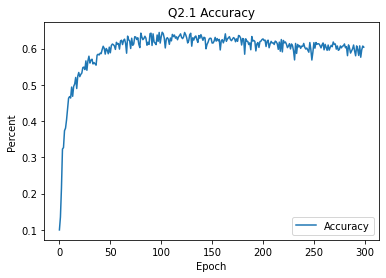

In [25]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Percent")

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Q2.1 Accuracy")

Text(0.5, 1.0, 'Q2.2 Losses')

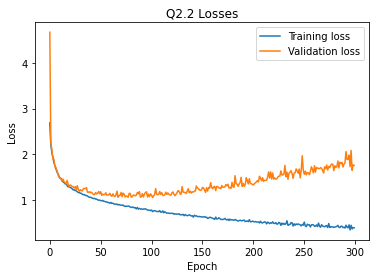

In [26]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Q2.2 Losses")

## Q2.2

In [27]:
class ResNetDropout(nn.Module):
    def __init__(self, n_channels1, n_blocks, p):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.blocks = nn.Sequential(*(n_blocks * [ResBlockDropout(n_channels1 = self.n_channels1, p = p)]))
        self.dropout = nn.Dropout2d(p = p)
        self.fc1 = nn.Linear(8 * 8 * self.n_channels1, 32)
        self.fc2 = nn.Linear(32, 10)  
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.dropout(self.conv1(x))), 2)
        out = f.max_pool2d(self.blocks(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
class ResBlockDropout(nn.Module):
    def __init__(self, n_channels1, p):
        super(ResBlockDropout, self).__init__()
        self.conv = nn.Conv2d(n_channels1, n_channels1, kernel_size = 3, padding = 1)
        self.dropout = nn.Dropout2d(p = p)    
    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = torch.relu(out)
        return out + x

In [29]:
class ResNetBatchNorm(nn.Module):
    def __init__(self, n_channels1, n_blocks):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(num_features = n_channels1)
        self.blocks = nn.Sequential(*(n_blocks * [ResBlockBatchNorm(n_channels1=self.n_channels1)]))
        self.batchnorm2 = nn.BatchNorm2d(num_features = n_channels1)
        self.fc1 = nn.Linear(8 * 8 * self.n_channels1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.batchnorm1(self.conv1(x))), 2)
        out = f.max_pool2d(self.batchnorm2(self.blocks(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
class ResBlockBatchNorm(nn.Module):
    def __init__(self, n_channels1):
        super(ResBlockBatchNorm, self).__init__()
        self.conv = nn.Conv2d(n_channels1, n_channels1, kernel_size = 3, padding = 1, bias = False)
        self.batch_norm = nn.BatchNorm2d(num_features = n_channels1)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [31]:
def training_loopl2(epochs, optimizer, model, loss_fn, train_loader, val_loader, l2_lambda):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        correct_labels = 0
        count = 0
        loss_val_value = 0
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                output = model(imgs)
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            
            loss_val_value /= len(val_loader)
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count) 
        loss_train_value = 0
        model.train()
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss_train = loss_fn(output, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss_train = loss_train + l2_lambda * l2_norm
            loss_train_value += float(loss_train)
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        loss_train_value /= len(train_loader)
        training_losses.append(loss_train_value)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train_value}", end="")
            print(f", Validation Loss: {loss_val_value}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

## L2

In [32]:
NUM_EPOCHS = 300
LEARNING_RATE = 3e-3
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10
LAMBDA = 0.001 
model = ResNet(NUM_CHANNELS, BLOCKS).to(device=device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [33]:
try:
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loopl2(NUM_EPOCHS, optimizer, model, 
                                                              loss, train_loader, val_loader, LAMBDA)
    end_time = time.time()
except Exception as err:
    print(err)

print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.4465741916578643, Validation Loss: 6.637887811660766, Accuracy: 9.959999999999999%
Epoch: 10, Training Loss: 1.701609068987321, Validation Loss: 1.6318924188613892, Accuracy: 41.36%
Epoch: 20, Training Loss: 1.4326142948500964, Validation Loss: 1.3925409317016602, Accuracy: 50.27%
Epoch: 30, Training Loss: 1.2675078499073884, Validation Loss: 1.2663134813308716, Accuracy: 54.690000000000005%
Epoch: 40, Training Loss: 1.1624667887784996, Validation Loss: 1.152190101146698, Accuracy: 59.099999999999994%
Epoch: 50, Training Loss: 1.0906796139113757, Validation Loss: 1.0988343000411986, Accuracy: 60.84%
Epoch: 60, Training Loss: 1.0231374173748249, Validation Loss: 1.0662755489349365, Accuracy: 61.92999999999999%
Epoch: 70, Training Loss: 0.9801439460442991, Validation Loss: 1.0584646105766295, Accuracy: 62.56%
Epoch: 80, Training Loss: 0.9412195828496194, Validation Loss: 1.0238568007946014, Accuracy: 64.13%
Epoch: 90, Training Loss: 0.901390824999128, Validatio

Text(0.5, 1.0, 'Q2.2 L2 regularization Accuracy')

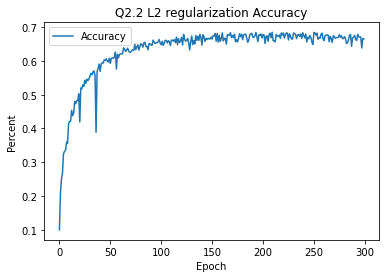

In [34]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Percent")

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Q2.2 L2 regularization Accuracy")

Text(0.5, 1.0, 'Q2.2 L2 regularization Losses')

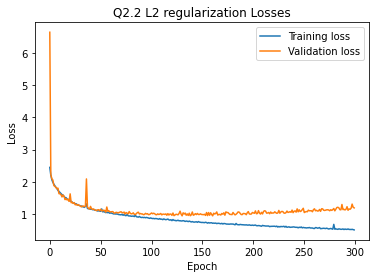

In [35]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Q2.2 L2 regularization Losses")

## Dropout

In [36]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10
DROPOUT_RATE = 0.3
model = ResNetDropout(NUM_CHANNELS, BLOCKS, DROPOUT_RATE).to(device=device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)
val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [37]:
try:
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)

print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.3061041831970215, Validation Loss: 3.0537944078445434, Accuracy: 10.57%
Epoch: 10, Training Loss: 1.5509266245121858, Validation Loss: 1.4956057667732239, Accuracy: 47.980000000000004%
Epoch: 20, Training Loss: 1.349918015149175, Validation Loss: 1.264099109172821, Accuracy: 54.87%
Epoch: 30, Training Loss: 1.231185117546393, Validation Loss: 1.1760206341743469, Accuracy: 58.06%
Epoch: 40, Training Loss: 1.1500224823854408, Validation Loss: 1.1063201665878295, Accuracy: 60.650000000000006%
Epoch: 50, Training Loss: 1.0888395917658904, Validation Loss: 1.1283604741096496, Accuracy: 59.38%
Epoch: 60, Training Loss: 1.03216360418164, Validation Loss: 1.0247797548770905, Accuracy: 63.849999999999994%
Epoch: 70, Training Loss: 0.9888658438410077, Validation Loss: 1.0143685698509217, Accuracy: 64.51%
Epoch: 80, Training Loss: 0.9613351700257282, Validation Loss: 1.0167768716812133, Accuracy: 64.84%
Epoch: 90, Training Loss: 0.9293297565713221, Validation Loss: 0.99

Text(0.5, 1.0, 'Q2.2 Dropout Accuracy')

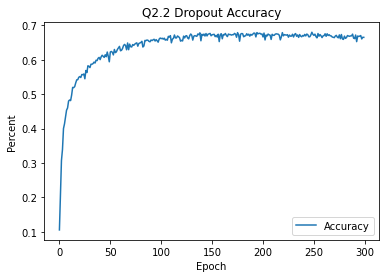

In [38]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Percent")

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Q2.2 Dropout Accuracy")

Text(0.5, 1.0, 'Q2.2 Dropout Losses')

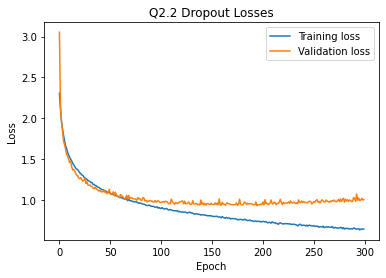

In [39]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Q2.2 Dropout Losses")

## Batch

In [40]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10
model = ResNetBatchNorm(NUM_CHANNELS, BLOCKS).to(device=device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)
val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [41]:
try:
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)

print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.086832593898384, Validation Loss: 7.368177366256714, Accuracy: 10.07%
Epoch: 10, Training Loss: 1.2330383767887039, Validation Loss: 1.7034066319465637, Accuracy: 39.269999999999996%
Epoch: 20, Training Loss: 1.0378789390836443, Validation Loss: 1.6764916896820068, Accuracy: 40.67%
Epoch: 30, Training Loss: 0.9187548890405771, Validation Loss: 1.7396256804466248, Accuracy: 41.11%
Epoch: 40, Training Loss: 0.8473518904374571, Validation Loss: 1.6318194389343261, Accuracy: 45.129999999999995%
Epoch: 50, Training Loss: 0.7877432752628716, Validation Loss: 1.7331885933876037, Accuracy: 44.28%
Epoch: 60, Training Loss: 0.7388789872733914, Validation Loss: 1.8925063967704774, Accuracy: 41.730000000000004%
Epoch: 70, Training Loss: 0.6997274306355691, Validation Loss: 1.8390644073486329, Accuracy: 43.46%
Epoch: 80, Training Loss: 0.6645647263040348, Validation Loss: 1.9044485092163086, Accuracy: 42.55%
Epoch: 90, Training Loss: 0.626940550852795, Validation Loss: 1.

Text(0.5, 1.0, 'Q2.2 Batch Normalization Accuracy')

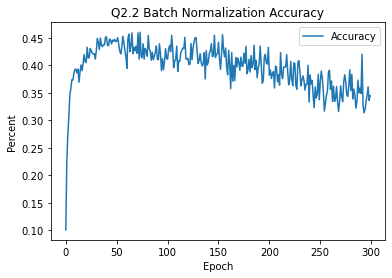

In [42]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Percent")

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Q2.2 Batch Normalization Accuracy")

Text(0.5, 1.0, 'Q2.2 Batch Normalization Losses')

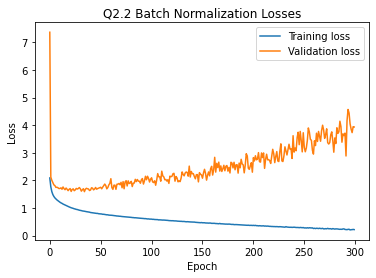

In [43]:
fig = plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Q2.2 Batch Normalization Losses")

In [44]:
model_l2 = ResNet(32, 10)
model_dropout = ResNetDropout(32, 10, 0.3)
model_batchnorm = ResNetBatchNorm(32, 10)

macs, params = get_model_complexity_info(model_l2, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
print("L2 regularization")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model_dropout, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
print("Dropout")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model_batchnorm, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
print("Batch Normalization")
print("Model size: " + params)

L2 regularization
Model size: 76.04 k

Dropout
Model size: 76.04 k

Batch Normalization
Model size: 76.2 k
